This notebook works through a set of tests to calculate the weights daymet contributing cells to each hru in GFv11

In [ ]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json

In [2]:
print(os.getcwd())
from pathlib import Path
folder = Path(r'../Data') # assumes working directory is onhm-fetcher-parser
print(folder)
shapefiles = folder.glob("*_0[1].shp")
#shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
print(gdf)

B:\GitRepos\onhm-fetcher-parser\notebooks
..\Data
       POI_ID  hru_id_nat  hru_id_reg region  \
0     7733855           1           1     01   
1     7733919           2           2     01   
2     7732571           3           3     01   
3     7732387           4           4     01   
4     7733327           5           5     01   
...       ...         ...         ...    ...   
2457   719280        2458        2458     01   
2458   805345        2459        2459     01   
2459   806793        2460        2460     01   
2460   807073        2461        2461     01   
2461   725382        2462        2462     01   

                                               geometry  
0     POLYGON ((-73.37148 41.11233, -73.37151 41.112...  
1     POLYGON ((-73.38532 41.13467, -73.38566 41.134...  
2     POLYGON ((-73.41947 41.16068, -73.41955 41.160...  
3     POLYGON ((-73.41097 41.15833, -73.41105 41.158...  
4     MULTIPOLYGON (((-73.28636 41.12781, -73.28645 ...  
...                      

The code below (used when all hru shapefiles are read) is not optimum because it's base on the centroid of the hrus.  Therefore these boundary values are better and cover hrus outside the conus -126 54 -65 23

In [3]:
type(gdf['geometry'].bounds['minx'])
west = gdf['geometry'].bounds['minx'].min()
east = gdf['geometry'].bounds['maxx'].max()
south = gdf['geometry'].bounds['miny'].min()
north = gdf['geometry'].bounds['maxy'].max()
print(west, north, east, south)

-73.73815293899997 48.100042571000074 -66.94953853699997 40.98519585200006


#### Some example URLs for for daymet
 
https://thredds.daac.ornl.gov/thredds/ncss/grid/daymet-v3-agg/na.ncml/dataset.html

https://thredds.daac.ornl.gov/thredds/ncss/daymet-v3-agg/na.ncml?var=lat&var=lon&var=dayl&var=prcp&var=srad&var=swe&var=tmax&var=tmin&var=vp&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2019-09-22T12%3A00%3A00Z&time_end=2018-12-31T12%3A00%3A00Z&timeStride=1&accept=netcdf

In [4]:
import requests
from requests.exceptions import HTTPError
from datetime import datetime, timedelta
from urllib.parse import urlencode

prcpurl = 'https://thredds.daac.ornl.gov/thredds/ncss/daymet-v3-agg/na.ncml'
prcppayload = {
#     'var': 'lat&var=lon&var=tmax',
    'var': 'lat&var=lon&var=prcp&var=srad&var=swe&var=tmax&var=tmin&var=vp',
    'north': '54',
    'west': '-126',
    'east': '-65',
    'south': '20',
    'disableProjSubset': 'on',
    'horizStride': '1',
    'time_start': '2018-12-31T12:00:00Z',
    'time_end': '2018-12-31T12:00:00Z',
    'timeStride': '1',
    'accept': 'netcdf'}    
try:
    s = requests.Session()
    #https://github.com/psf/requests/issues/1454
    qry = urlencode(prcppayload).replace('%26','&')
    qry = qry.replace('%3D', '=')
    print(qry)
    tmaxfile = requests.get(prcpurl, params=qry)
    tmaxfile.raise_for_status()
except HTTPError as http_err:
    print(f'HTTP error occured: {http_err}')
except Exception as err:
    print(f'Other error occured: {err}')
else:
    print('Gridmet data retrieved!')

var=lat&var=lon&var=prcp&var=srad&var=swe&var=tmax&var=tmin&var=vp&north=54&west=-126&east=-65&south=20&disableProjSubset=on&horizStride=1&time_start=2018-12-31T12%3A00%3A00Z&time_end=2018-12-31T12%3A00%3A00Z&timeStride=1&accept=netcdf
Gridmet data retrieved!


In [5]:
with open('tmax_test2.nc', 'wb') as fh:
    fh.write(tmaxfile.content)
fh.close

<function BufferedWriter.close>

In [6]:
#=========================================================
#            MACAV2METDATA FILE PARAMETERS
#=========================================================
# dirPath='https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_prcp_2018_na.nc4?var=lat&var=lon&var=prcp&north=52.880049298000074+&west=-124.72462483099997+&east=-66.94953853699997+&south=24.839424370000074&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2018-12-31T00:00:00Z&time_end=2018-12-31T00:00:00Z&timeStride=1&accept=netcdf'
# fileName='/thredds/dodsC/MET/tmmx/tmmx_2019.nc'
dirPath = 'tmax_test2.nc'
# dirPath = 'daymet_v3_tmax_2018_na.nc4.nc'
#--------------------------------------------------------
#   FORM FILENAME AND GET HANDLE TO FILE AND DATA
#--------------------------------------------------------
fullfilename= dirPath
print(fullfilename)

ds = xr.open_dataset(fullfilename)

print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', ds.attrs)
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['time']
datahandle=ds['tmax']
dhlat = ds['lat']
dhlon = ds['lon']
crshandle=ds['lambert_conformal_conic']
print('\n The crs meta data is \n', crshandle.attrs)
print(datahandle)
# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
# lonres = float(ds.attrs['geospatial_lon_resolution'])
# latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
print('\n Data attributes are: \n',datahandle.attrs)
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)
print('\n Lat coords are: \n', dhlat.attrs)

ts = datahandle.sizes
print(type(ts))
print(ts['time'])
dayshape = ts['time']
Lonshape = ts['x']
Latshape = ts['y']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)

# datahandle.values[dayshape-1,:,:].shape

# print(lathandle.values.shape)
# print(type(lathandle.values))
# print(datahandle.dtype)
# print(np.isfortran(datahandle.values))

tmax_test2.nc
<xarray.Dataset>
Dimensions:                  (time: 1, x: 6008, y: 3699)
Coordinates:
  * y                        (y) float32 1687.0 1686.0 ... -2010.0 -2011.0
  * x                        (x) float32 -2754.25 -2753.25 ... 3251.75 3252.75
  * time                     (time) datetime64[ns] 2018-12-31
Data variables:
    lat                      (y, x) float32 ...
    lambert_conformal_conic  int16 ...
    lon                      (y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    _NCProperties:       version=1|netcdflibversion=4.4.1|hdf5libversion=1.8.17
    start_year:          1980
    source:              Daymet Software Version 3.0
    Version_software:    Daymet S

In [7]:
print(np.min(dhlat.values))

18.55824


In [8]:
ds.variables.keys()

KeysView(Frozen({'lat': <xarray.Variable (y: 3699, x: 6008)>
array([[51.525253, 51.529858, 51.534462, ..., 49.08202 , 49.076797, 49.07157 ],
       [51.517143, 51.521744, 51.52635 , ..., 49.074226, 49.069   , 49.063778],
       [51.50903 , 51.513634, 51.518234, ..., 49.06643 , 49.061207, 49.055984],
       ...,
       [20.018337, 20.021029, 20.023722, ..., 18.580685, 18.577593, 18.5745  ],
       [20.009981, 20.012672, 20.015364, ..., 18.572556, 18.569464, 18.56637 ],
       [20.001625, 20.004316, 20.007008, ..., 18.564425, 18.561333, 18.55824 ]],
      dtype=float32)
Attributes:
    units:                degrees_north
    long_name:            latitude coordinate
    standard_name:        latitude
    _ChunkSizes:          [1010  977]
    _CoordinateAxisType:  Lat
    grid_mapping:         lambert_conformal_conic, 'y': <xarray.IndexVariable 'y' (y: 3699)>
array([ 1687.,  1686.,  1685., ..., -2009., -2010., -2011.], dtype=float32)
Attributes:
    units:          km
    long_name:      

In [9]:
tmax = ds.variables['tmax'][:]  # Reads the whole array
tmax

<xarray.Variable (time: 1, y: 3699, x: 6008)>
[22223592 values with dtype=float32]
Attributes:
    long_name:     daily maximum temperature
    units:         degrees C
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: maximum
    _ChunkSizes:   [   1 1000 1000]

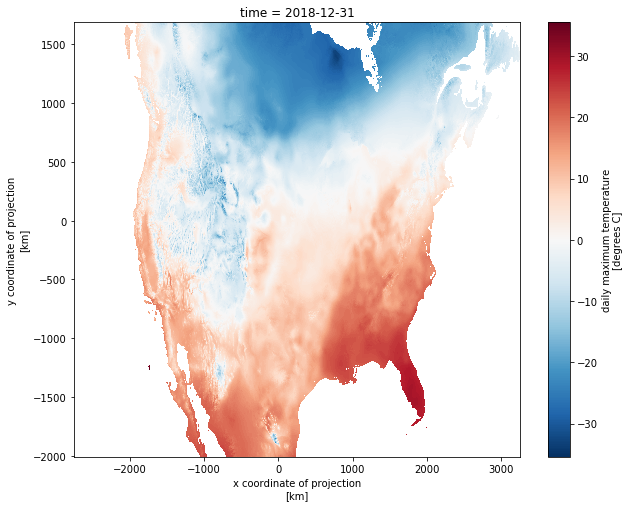

In [91]:
ds.tmax.plot()

<class 'xarray.core.dataarray.DataArray'>
(3699, 6008)


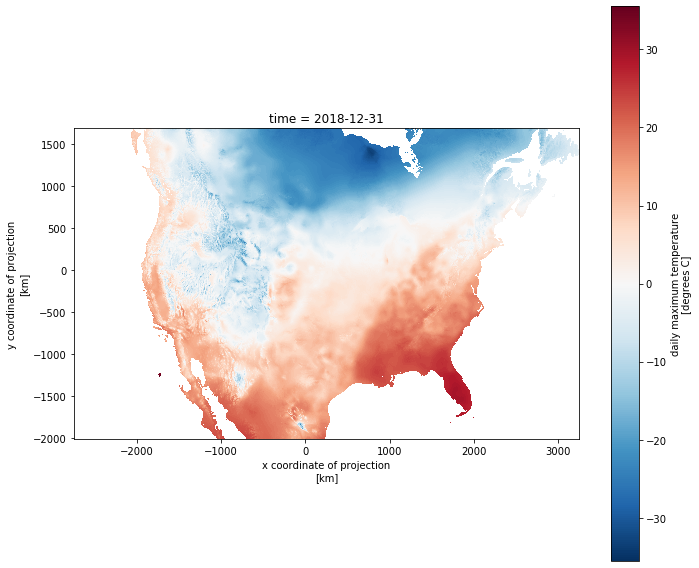

In [92]:
f1, ax1 = plt.subplots(1)
ax1.set_aspect('equal')
# ax1.set(xlim=(-130, -60), ylim=(20, 55))
ptmax = ds.tmax
ptmax_1 = ptmax.isel(time=0)
print(type(ptmax_1))
print(ptmax_1.shape)
# ptmax_1.plot(ax=ax1, x='x', y='y', cmap='viridis')
ds.tmax.plot(ax=ax1, x='x', y='y')
f1.tight_layout()
f1.savefig('daymet.png')

In [ ]:
import cartopy.crs as ccrs
ax = plt.subplot(projection=ccrs.PlateCarree());
ds.tmax.plot(ax=ax);
# ax.scatter(ds.lon, ds.lat, transform=ccrs.PlateCarree(),s=0.001);
# ax.coastlines(); 
ax.gridlines(draw_labels=True);
fig = plt.gcf()
fig.set_size_inches(15,15)

In [ ]:
for i in range(1,10): print(i)

In [10]:
lon = ds.lon.values
lat = ds.lat.values
print(np.shape(lon)[0], np.shape(lon)[1])

3699 6008


In [12]:
from shapely.geometry import Polygon
def distance(p1x, p1y, p2x, p2y):
    return np.sqrt(np.power((p2x-p1x),2) + np.power((p2y-p1y),2))

lon = ds.lon.values
lat = ds.lat.values
df = pd.DataFrame({'temperature': ds.tmax.values.flatten()})
res = 0.04166666/2.0
numcells = np.shape(lat)[0]*np.shape(lat)[1]
poly = []
index = np.zeros(numcells)
count = 0

numcells = (np.shape(lat)[0]) * (np.shape(lat)[1]) 
poly = []
index = np.zeros(numcells, dtype=int)

for j in range(np.shape(lon)[1]):
    if j%10 == 0: print(j)
    for i in range(np.shape(lon)[0]):
        jm1 = j-1
        jp1 = j+1
        im1 = i-1
        ip1 = i+1
        if j == 0:
            jm1 = 0
            j = 1
        if j == np.shape(lon)[1]-1:
            jp1 = j
            j = j-1
        if i == 0:
            im1 = 0
            i = 1
        if i == np.shape(lon)[0]-1:
            ip1 = i
            i = i-1
                
        tpoly_1_lon = [lon[i,j], lon[i,jm1], lon[ip1,jm1], lon[ip1, j]]
        tpoly_1_lat = [lat[i,j], lat[i,jm1], lat[ip1,jm1], lat[ip1, j]]
        tpoly_1 = Polygon(zip(tpoly_1_lon, tpoly_1_lat))
        p1 = tpoly_1.centroid
        
        tpoly_2_lon = [lon[i,j], lon[ip1,j], lon[ip1,jp1], lon[i, jp1]]
        tpoly_2_lat = [lat[i,j], lat[ip1,j], lat[ip1,jp1], lat[i, jp1]]
        tpoly_2 = Polygon(zip(tpoly_2_lon, tpoly_2_lat))
        p2 = tpoly_2.centroid  
            
        tpoly_3_lon = [lon[i,j], lon[i,jp1], lon[im1,jp1], lon[im1, j]]
        tpoly_3_lat = [lat[i,j], lat[i,jp1], lat[im1,jp1], lat[im1, j]]
        tpoly_3 = Polygon(zip(tpoly_3_lon, tpoly_3_lat))
        p3 = tpoly_3.centroid  

        tpoly_4_lon = [lon[i,j], lon[im1,j], lon[im1,jm1], lon[i, jm1]]
        tpoly_4_lat = [lat[i,j], lat[im1,j], lat[im1,jm1], lat[i, jm1]]
        tpoly_4 = Polygon(zip(tpoly_4_lon, tpoly_4_lat))
        p4 = tpoly_4.centroid  
            
        lon_point_list = [p1.x, p2.x, p3.x, p4.x]
        lat_point_list = [p1.y, p2.y, p3.y, p4.y]
            
        poly.append(Polygon(zip(lon_point_list, lat_point_list)))
        index[count] = count
        count += 1

ncfcells = gpd.GeoDataFrame(df, index=index, geometry=poly)
ncfcells.dropna(subset=['temperature'], inplace=True)
print('finished creating daymet cells - now writting file - may take a while')


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [15]:
print('Creating Spatial Index - This could take some time')
spatial_index = ncfcells.sindex
print('Finished Spatial Index')

Creating Spatial Index - This could take some time
Finished Spatial Index


In [20]:
import csv
tcount = 0
with open('tmp2_weights2.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for index, row in gdf.iterrows():
        if index == 0:
            count = 0
            if tcount == 0:
                writer.writerow(['grid_ids', 'hru_id_nat', 'w'])
            possible_matches_index = list(spatial_index.intersection(row['geometry'].bounds))
            if not(len(possible_matches_index) == 0):
                possible_matches = ncfcells.iloc[possible_matches_index]
                precise_matches = possible_matches[possible_matches.intersects(row['geometry'])]
                if not(len(precise_matches) == 0):
                    res_intersection = gpd.overlay(gdf.loc[[index]], precise_matches, how='intersection')
                    for nindex, row in res_intersection.iterrows():
                        tmpfloat = np.float(res_intersection.area.iloc[nindex]/gdf.loc[[index], 'geometry'].area)
                        writer.writerow([np.int(precise_matches.index[count]), np.int(row['hru_id_nat']), tmpfloat])
                        count += 1
                    tcount += 1
                    if tcount%100 == 0:
                        print(tcount, index)
            else:
                print('no intersection: ', index, np.int(row['nhm_id']))

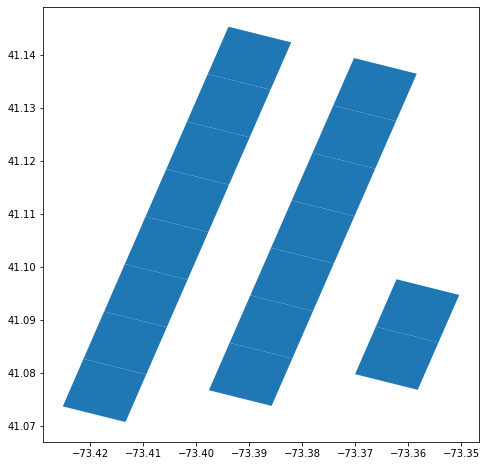

In [25]:
possible_matches.plot()

0 0 17941648 1 0.0024170452462120686
1 1 17949045 1 0.006749249380300051
2 2 17941647 1 0.00647454326755944
3 3 17949044 1 0.0019733862725098816
4 4 17941646 1 0.002377373704663305
5 5 17949043 1 9.984684461423372e-05
6 6 17941645 1 0.0003564286973252698
7 7 17941644 1 0.001739244396727284
8 8 17949048 1 0.004225913807795237
9 9 17949047 1 0.00509096085489361
10 10 17941649 1 0.006419812594666977
11 11 17949046 1 0.0008902053086334351
0     0.000029
1     0.000080
2     0.000077
3     0.000023
4     0.000028
5     0.000001
6     0.000004
7     0.000021
8     0.000050
9     0.000060
10    0.000076
11    0.000011
dtype: float64 0.00045946709571556543 0    0.001074
dtype: float64


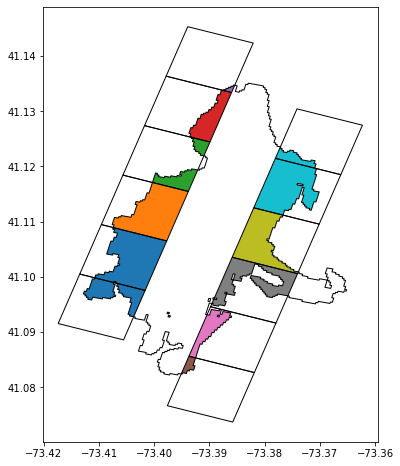

In [21]:
ax = res_intersection.plot(cmap='tab10')
ax = gdf.loc[[0], 'geometry'].plot(ax=ax, facecolor='none', edgecolor='k')
precise_matches.plot(ax=ax, facecolor='none', edgecolor='k')
count = 0
for nindex, row in res_intersection.iterrows():
    tmpfloat = np.float(res_intersection.area.iloc[nindex]/gdf.loc[[index], 'geometry'].area)
    # writer.writerow([np.int(precise_matches.index[count]), np.int(row['GFv11_id']), np.int(row['hru_id_nat']), tmpfloat])
    #writer.writerow([np.int(precise_matches.index[count]), np.int(row['GFv11_id']), tmpfloat])
    print(nindex, count, np.int(precise_matches.index[count]), np.int(row['hru_id_nat']), tmpfloat)
    count += 1
print(res_intersection.area, np.sum(res_intersection.area), gdf.loc[[0], 'geometry'].area)

In [27]:
from shapely.geometry import Polygon
def distance(p1x, p1y, p2x, p2y):
    return np.sqrt(np.power((p2x-p1x),2) + np.power((p2y-p1y),2))

#first create dataframe with temp
df = pd.DataFrame({'temperature': ds.tmax.values.flatten()})
res = 0.04166666/2.0
numcells2 = (np.shape(lat)[0]-2)*(np.shape(lat)[1]-2) # -2 to ignore boundaries, daymet domain should well overlap conus
poly2 = []
index2 = np.zeros(numcells2)
count = 0
# ncfcell = gpd.GeoDataFrame()
# ncfcell['geometry'] = None

for i in range(1, np.shape(lon)[0]-1):
    if i%10 == 0: print(i)
    for j in range(1, np.shape(lon)[1]-1):
        
        tpoly_1_lon = [lon[i,j], lon[i,j-1], lon[i+1,j-1], lon[i+1, j]]
        tpoly_1_lat = [lat[i,j], lat[i,j-1], lat[i+1,j-1], lat[i+1, j]]
        tpoly_1 = Polygon(zip(tpoly_1_lon, tpoly_1_lat))
        p1 = tpoly_1.centroid
        
        tpoly_2_lon = [lon[i,j], lon[i+1,j], lon[i+1,j+1], lon[i, j+1]]
        tpoly_2_lat = [lat[i,j], lat[i+1,j], lat[i+1,j+1], lat[i, j+1]]
        tpoly_2 = Polygon(zip(tpoly_2_lon, tpoly_2_lat))
        p2 = tpoly_2.centroid  
        
        tpoly_3_lon = [lon[i,j], lon[i,j+1], lon[i-1,j+1], lon[i-1, j]]
        tpoly_3_lat = [lat[i,j], lat[i,j+1], lat[i-1,j+1], lat[i-1, j]]
        tpoly_3 = Polygon(zip(tpoly_3_lon, tpoly_3_lat))
        p3 = tpoly_3.centroid  

        tpoly_4_lon = [lon[i,j], lon[i-1,j], lon[i-1,j-1], lon[i, j-1]]
        tpoly_4_lat = [lat[i,j], lat[i-1,j], lat[i-1,j-1], lat[i, j-1]]
        tpoly_4 = Polygon(zip(tpoly_4_lon, tpoly_4_lat))
        p4 = tpoly_4.centroid  
        
        lon_point_list = [p1.x, p2.x, p3.x, p4.x]
        lat_point_list = [p1.y, p2.y, p3.y, p4.y]
        
        poly2.append(Polygon(zip(lon_point_list, lat_point_list)))
        index2[count] = count
        count += 1
# ncfcells = gpd.GeoDataFrame(df, index=index, crs=ds['crs'], geometry=poly)  
ncfcells2 = gpd.GeoDataFrame(df, index=index2, geometry=poly2)  
ncfcells2.head()
print('Creating Spatial Index - This could take some time')
spatial_index2 = ncfcells2.sindex
print('Finished Spatial Index')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

In [82]:
import csv
tcount = 0
vhruid = 1217
with open('tmp2_weights2t.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for index, row in gdf.iterrows():
#         print(index, row)
        if np.int(row['hru_id_nat']) == vhruid :
            count = 0
            if tcount == 0:
                writer.writerow(['grid_ids', 'hru_id_nat', 'w'])
            possible_matches_index = list(spatial_index2.intersection(row['geometry'].bounds))
            if not(len(possible_matches_index) == 0):
                possible_matches = ncfcells2.iloc[possible_matches_index]
                precise_matches = possible_matches[possible_matches.intersects(row['geometry'])]
                if not(len(precise_matches) == 0):
                    res_intersection = gpd.overlay(gdf.loc[[index]], precise_matches, how='intersection')
                    for nindex, row in res_intersection.iterrows():
                        ttt = gdf.loc[[index], 'geometry'].area
                        tmpfloat = np.float(res_intersection.area.iloc[nindex]/ttt[index])
                        writer.writerow([np.int(precise_matches.index[count]), np.int(row['hru_id_nat']), tmpfloat])
                        count += 1
                    tcount += 1
                    if tcount%100 == 0:
                        print(tcount, index)
        
            else:
                print('no intersection: ', index, np.int(row['nhm_id']))
            break

In [87]:
res_intersection


,POI_ID,hru_id_nat,hru_id_reg,region,tmax,temperature,geometry
0,5879195,1217,1217,01,4.849044,-3.5,"POLYGON ((-70.01332 41.79844, -70.01319 41.798..."
1,5879195,1217,1217,01,4.849044,-3.5,"POLYGON ((-69.94708 41.79613, -69.94685 41.796..."
2,5879195,1217,1217,01,4.849044,-3.5,"MULTIPOLYGON (((-69.97866 41.78991, -69.97858 ..."
3,5879195,1217,1217,01,4.849044,-4.0,"POLYGON ((-70.02067 41.79164, -70.02058 41.791..."
4,5879195,1217,1217,01,4.849044,-3.5,"MULTIPOLYGON (((-69.94604 41.79821, -69.94596 ..."
...,...,...,...,...,...,...,...
832,5879195,1217,1217,01,4.849044,-3.5,"POLYGON ((-70.71144 41.98315, -70.71143 41.983..."
833,5879195,1217,1217,01,4.849044,-4.0,"POLYGON ((-70.71527 41.98589, -70.71534 41.985..."
834,5879195,1217,1217,01,4.849044,-3.5,"POLYGON ((-70.69965 41.99026, -70.69938 41.990..."
835,5879195,1217,1217,01,4.849044,-3.5,"POLYGON ((-70.70943 41.99265, -70.70939 41.992..."


daymet_index hru_index intersection_area hru_area weight cumulative_weight
7932979 1217 0.00011827813169594322 0.0687787814527367 0.001719689258775563 0.001719689258775563
7932978 1217 0.00011151354624261795 0.0687787814527367 0.0016213364628922316 0.0033410257216677946
7932977 1217 5.6381516860305966e-05 0.0687787814527367 0.0008197516104447144 0.0041607773321125086
7926973 1217 1.4380017591502253e-05 0.0687787814527367 0.00020907636465446674 0.004369853696766976
7932976 1217 9.602240831945977e-05 0.0687787814527367 0.0013961051110718543 0.00576595880783883
7938984 1217 0.0001190772510051126 0.0687787814527367 0.0017313079483232763 0.007497266756162107
8029099 1217 0.00010783122967913379 0.0687787814527367 0.0015677979080398958 0.009065064664202002
8035102 1217 8.88437790224127e-05 0.0687787814527367 0.0012917323794615963 0.010356797043663598
8023095 1217 3.388530092065949e-05 0.0687787814527367 0.0004926708529133326 0.01084946789657693
8029098 1217 8.177974689456993e-05 0.06877878145

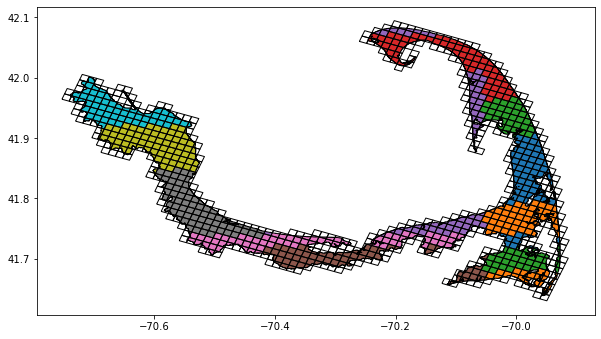

In [90]:
ax = res_intersection.plot(cmap='tab10')
ax = gdf.loc[[index], 'geometry'].plot(ax=ax, facecolor='none', edgecolor='k')
precise_matches.plot(ax=ax, facecolor='none', edgecolor='k')
# index = 0
count = 0
cumwght = 0
for nindex, row in res_intersection.iterrows():
    ttt = gdf.loc[[index], 'geometry'].area
    tmpfloat = np.float(res_intersection.area.iloc[nindex]/ttt[index])
    # writer.writerow([np.int(precise_matches.index[count]), np.int(row['GFv11_id']), np.int(row['hru_id_nat']), tmpfloat])
    #writer.writerow([np.int(precise_matches.index[count]), np.int(row['GFv11_id']), tmpfloat])
    cumwght+=tmpfloat
    if nindex == 0:
        print('daymet_index', 'hru_index', 'intersection_area', 'hru_area', 'weight', 'cumulative_weight')
    print(np.int(precise_matches.index[count]), np.int(row['hru_id_nat']), res_intersection.area.iloc[nindex], ttt[index], tmpfloat, cumwght)
    count += 1
print(res_intersection.area, np.sum(res_intersection.area), gdf.loc[[index], 'geometry'].area)

In [76]:
import csv
tcount = 0
with open('tmp2_weights2t.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for index, row in gdf.iterrows():
        count = 0
        if tcount == 0:
            writer.writerow(['grid_ids', 'hru_id_nat', 'w'])
        possible_matches_index = list(spatial_index2.intersection(row['geometry'].bounds))
        if not(len(possible_matches_index) == 0):
            possible_matches = ncfcells2.iloc[possible_matches_index]
            precise_matches = possible_matches[possible_matches.intersects(row['geometry'])]
            if not(len(precise_matches) == 0):
                res_intersection = gpd.overlay(gdf.loc[[index]], precise_matches, how='intersection')
                for nindex, row in res_intersection.iterrows():
                    ttt = gdf.loc[[index], 'geometry'].area
                    tmpfloat = np.float(res_intersection.area.iloc[nindex]/ttt[index])
                    writer.writerow([np.int(precise_matches.index[count]), np.int(row['hru_id_nat']), tmpfloat])
                    count += 1
                tcount += 1
                if tcount%100 == 0:
                    print(tcount, index)
        
            else:
                print('no intersection: ', index, np.int(row['nhm_id']))


100 99
200 199
300 299
400 399
500 499
600 599
700 699
800 799
900 899
1000 999
1100 1099
1200 1199
1300 1299
1400 1399
1500 1499
1600 1599
1700 1699
1800 1799
1900 1899
2000 1999
2100 2099
2200 2199
2300 2299
2400 2399


   grid_ids  hru_id_nat         w
0   8977813           1  0.026643
1   8971808           1  0.074396
2   8971807           1  0.071368
3   9001838           1  0.020091
4   9001837           1  0.021752
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810

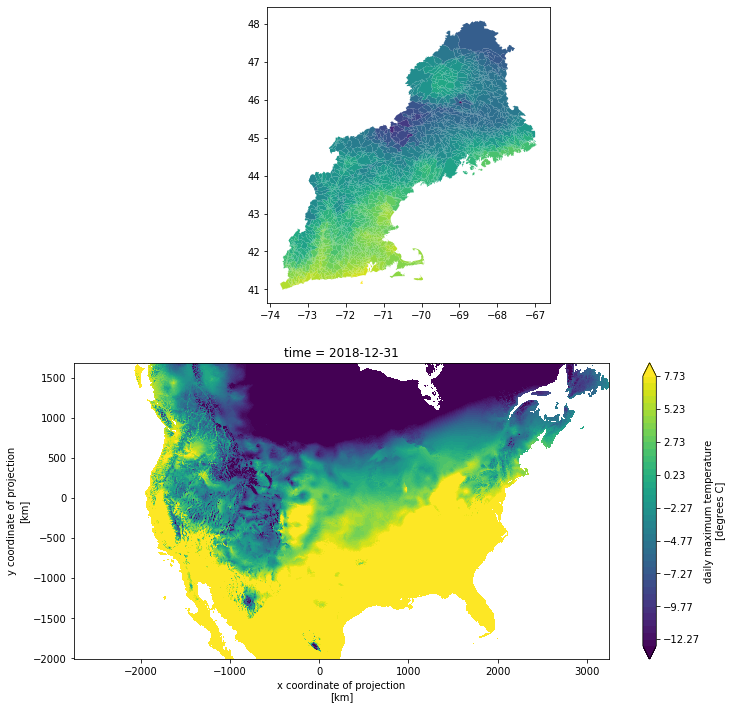

In [79]:
from numpy.ma import masked
# add tmax column to dataframe
gdf['tmax']=0.0
# gdf.tmax[noint] = 10.0
# print(gdf.tmax[noint])

wght_UofI = pd.read_csv('tmp2_weights2t.csv')
print(wght_UofI.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
# ndata = datahandle.values[dayshape-1,:,:].flatten(order='C')
# ndata = ds.tmax.values[dayshape-1,:,:].flatten()
lon = ds.lon.values
lat = ds.lat.values
ndata = np.zeros(np.shape(lon)[1]*np.shape(lon)[0])
tlc = 0
for i in range(1, np.shape(lon)[0]-1):
    if i%10 == 0: print(i)
    for j in range(1, np.shape(lon)[1]-1):
        ndata[tlc] = datahandle.values[dayshape-1,i,j]
        tlc+=1

# print(ndata[1000:])
hruid = 'GFv11_id'
hruid = 'hru_id_nat'
unique_hru_ids = wght_UofI.groupby(hruid)
print(len(gdf), len(unique_hru_ids))

def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
def np_get_wval(ndata, wghts, hru_id):
    """
    Returns weighted average of ndata with weights = grp
    1) mdata = the subset of values associated with the gridmet id's that are mapped to hru_id.
    2) Some of these values may have nans if the gridmet id is outside of conus so only return values
    that are inside of conus
    3) this means that hru's that are entirely outside of conus will return nans which will ultimately,
    outside of this function get assigned zero's.
    4) the value is assigned the weighted average
    :param ndata: float array of data values
    :param wghts: float array of weights
    :param hru_id hru id number
    :return: numpy weighted averaged - masked to deal with nans associated with
            ndata that is outside of the conus.
    """
    mdata = np.ma.masked_array(ndata[wghts['grid_ids'].values.astype(int)],
                               np.isnan(ndata[wghts['grid_ids'].values.astype(int)]))

    # mdata = np.ma.masked_where(ndata[wghts['grid_ids'].values.astype(int)] <= 0.0,
    #                            (ndata[wghts['grid_ids'].values.astype(int)]))
    tmp = np.ma.average(mdata, weights=wghts['w'])
    if tmp is masked:
        # print('returning masked value', hru_id, mdata, wghts['w'])
        return np.nan

    else:
        return tmp
    
# unique_hru_ids.get_group(gdf['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})    
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
#     if not(row['nhm_id'] in noint):
    try: 
        weight_id_rows = unique_hru_ids.get_group(row[hruid])
        td[index] = np.nan_to_num(np_get_wval(ndata, weight_id_rows, index+1))
    except KeyError:
        td[index] = 0.0
            
            
#         gdf['tmax'][index] = np_get_wval2(weight_id_rows, ndata)
#     else:
#         td[index] = 10.0

gdf['tmax'] = td.tolist()
# gdf['tmax'].fillna(0.0)

print('min/max', gdf['tmax'].min(), gdf['tmax'].max())

f, ax = plt.subplots(2, figsize=(12,12))
gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white')
ax[0].set_aspect('equal')
ptmax = ds.tmax
ptmax_1 = ptmax.isel(time=dayshape-1)
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
ptmax_1.plot(ax=ax[1], levels=lvs, cmap='viridis')

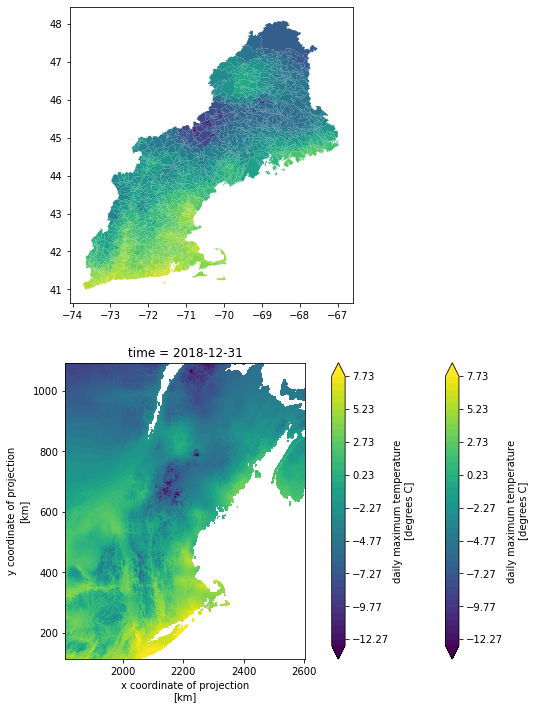

In [81]:
f, ax = plt.subplots(2, figsize=(12,12))
gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white')
ptmax = ds.tmax
ptmax_1 = ptmax.isel(time=dayshape-1)
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
ptmax_1.plot(ax=ax[1], levels=lvs, cmap='viridis')
# print(temp)
# print(temp.lat)
hru_1 = ptmax_1.where((ds.lon>=-74) & (ds.lon<=-67) & (ds.lat>=40.5) & (ds.lat<=48.5), drop=True)
# print(delaware)
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
p=hru_1.plot(ax=ax[1], levels=lvs, cmap='viridis')
ax[1].set_aspect('equal','box')